In [ ]:
# 🔧 Install essential packages
!pip install lightgbm xgboost catboost shap optuna imbalanced-learn tensorflow pyhdf --quiet
!apt install libgdal-dev -y
# 📂 Mount Google Drive
from google.colab import drive
drive.mount('/content/drive')

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.6/3.6 MB 39.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 253.9/253.9 MB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 99.2/99.2 MB 11.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 45.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 395.9/395.9 kB 25.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.4/238.4 kB 14.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 644.9/644.9 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 780.3/780.3 kB 35.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 247.0/247.0 kB 15.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.5/57.5 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.5/24.5 MB 81.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 319.9/319.9 kB 18.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3

In [ ]:
import os, numpy as np, pandas as pd, shap, optuna, warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.feature_selection import SelectFromModel
from imblearn.over_sampling import SMOTE

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier
from xgboost import XGBClassifier

import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Bidirectional, GRU, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from osgeo import gdal


In [ ]:
# 📂 DATA PATHS
t2m_files = [
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20120101_20121231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20130101_20131231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20140101_20141231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20150101_20151231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20160101_20161231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20170101_20171231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20180101_20181231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20190101_20191231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20200101_20201231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20210101_20211231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20220101_20221231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20230101_20231231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20240101_20241231 (2).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20250101_20250701 (2).csv",
  ]
rh2m_files=[
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20120101_20121231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20130101_20131231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20140101_20141231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20150101_20151231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20160101_20161231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20170101_20171231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20180101_20181231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20190101_20191231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20200101_20201231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20210101_20211231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20220101_20221231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20230101_20231231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20240101_20241231 (1).csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20250101_20250701 (1).csv",
  ]
precip_files =[
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20120101_20121231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20130101_20131231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20140101_20141231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20150101_20151231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20160101_20161231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20170101_20171231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20180101_20181231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20190101_20191231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20200101_20201231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20210101_20211231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20220101_20221231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20230101_20231231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20240101_20241231.csv",
  "/content/drive/MyDrive/forest fire prediction/Nasa_Regional_Datasets/POWER_Regional_Daily_20250101_20250701.csv",
  ]

In [ ]:
def clean_power_csv(path, var_name):
    # Manually assign columns since headers are missing
    cols = ['LAT', 'LON', 'YEAR', 'DOY', var_name]
    df = pd.read_csv(path, skiprows=10, header=None, names=cols)

    # Construct date column
    df['date'] = pd.to_datetime(df['YEAR'].astype(str) + df['DOY'].astype(str), format='%Y%j', errors='coerce')

    # Drop missing dates and return only necessary columns
    return df[['date', var_name]]


In [ ]:
merged_dfs = []
for t2m, rh2m, prc in zip(t2m_files, rh2m_files, precip_files):
    df_t2m = clean_power_csv(t2m, "T2M")
    df_rh2m = clean_power_csv(rh2m, "RH2M")
    df_prc = clean_power_csv(prc, "PRECTOTCORR")

    df_merged = df_t2m.merge(df_rh2m, on="date").merge(df_prc, on="date")
    merged_dfs.append(df_merged)

# Combine all years
all_power_df = pd.concat(merged_dfs).dropna().sort_values("date").reset_index(drop=True)


In [ ]:
def get_fire_dates(path):
    return pd.to_datetime(pd.read_csv(path)['acq_date'], errors='coerce').dt.date

base_path = "/content/drive/MyDrive/forest fire prediction"
fire_dates = pd.concat([
    get_fire_dates(f"{base_path}/fire_archive_M-C61_634087.csv"),
    get_fire_dates(f"{base_path}/fire_archive_SV-C2_634077.csv"),
    get_fire_dates(f"{base_path}/fire_nrt_M-C61_634087.csv"),
    get_fire_dates(f"{base_path}/fire_nrt_SV-C2_634077.csv"),
]).drop_duplicates()

all_power_df['fire_occurred'] = all_power_df['date'].dt.date.isin(fire_dates).astype(int)


In [ ]:
hdf_files = [
    f"{base_path}/MOD13Q1.A2019097.h25v07.061.2020292133029.hdf",
    f"{base_path}/MOD13Q1.A2019113.h25v07.061.2020293160321.hdf",
    f"{base_path}/MOD13Q1.A2019129.h25v07.061.2020294164703.hdf",
    f"{base_path}/MOD13Q1.A2019145.h25v07.061.2020298040829.hdf",
    f"{base_path}/MOD13Q1.A2019177.h25v07.061.2020303065601.hdf",
    f"{base_path}/MOD13Q1.A2019193.h25v07.061.2020304012321.hdf",
]

def extract_ndvi_mean(hdf_path):
    dataset = gdal.Open(hdf_path)
    subdataset = dataset.GetSubDatasets()[0][0]
    ndvi_data = gdal.Open(subdataset).ReadAsArray().astype(np.float32)
    ndvi_data[ndvi_data == -3000] = np.nan
    return round(np.nanmean(ndvi_data * 0.0001), 4)

ndvi_vals = [extract_ndvi_mean(fp) for fp in hdf_files]
for i, val in enumerate(ndvi_vals):
    all_power_df[f'ndvi_snapshot_{i+1}'] = val


In [ ]:
for col in ['T2M', 'RH2M']:
    for lag in range(1, 8):
        all_power_df[f'{col}_lag_{lag}'] = all_power_df[col].shift(lag).bfill()

all_power_df['month'] = all_power_df['date'].dt.month
all_power_df['day_of_year'] = all_power_df['date'].dt.dayofyear
all_power_df['season'] = all_power_df['month'].apply(lambda m: 0 if m in [12,1,2] else 1 if m in [3,4,5] else 2 if m in [6,7,8] else 3)
all_power_df = all_power_df.dropna().reset_index(drop=True)


In [ ]:
# ✅ Step 1: Dataset Prep (downsampling majority class)
majority = all_power_df[all_power_df['fire_occurred'] == 0].sample(n=3000,random_state=42)
minority = all_power_df[all_power_df['fire_occurred'] == 1]
reduced_df = pd.concat([majority, minority]).sample(frac=1, random_state=42)

# ✅ Step 2: Feature/Target split
X = reduced_df.drop(columns=['date', 'fire_occurred'])
y = reduced_df['fire_occurred']

# 🚨 SMOTE Checkpoint (paste this HERE!)
print("🔍 Before SMOTE:")
print("✅ Majority class (0):", (y == 0).sum())
print("✅ Minority class (1):", (y == 1).sum())
print("📊 Total samples:", len(X))

# ✅ Step 3: Apply SMOTE
from imblearn.over_sampling import SMOTE
smote = SMOTE(sampling_strategy=0.5, random_state=42)
X_res, y_res = smote.fit_resample(X, y)

# ✅ Optional: Check after SMOTE
print("🔄 After SMOTE Resampling:")
print("✅ Class 0:", (y_res == 0).sum())
print("✅ Class 1:", (y_res == 1).sum())
print("🧮 Total rows after SMOTE:", len(X_res))


🔍 Before SMOTE:
✅ Majority class (0): 3000
✅ Minority class (1): 26690202
📊 Total samples: 26693202
🔄 After SMOTE Resampling:
✅ Class 0: 13345101
✅ Class 1: 26690202
🧮 Total rows after SMOTE: 40035303


In [ ]:
from sklearn.utils import resample

# Downsample fire (1) to 10,000
fire_df = all_power_df[all_power_df['fire_occurred'] == 1].sample(n=10000, random_state=42)
non_fire_df = all_power_df[all_power_df['fire_occurred'] == 0]

reduced_df = pd.concat([non_fire_df, fire_df]).sample(frac=1, random_state=42)

X = reduced_df.drop(columns=['date', 'fire_occurred'])
y = reduced_df['fire_occurred']


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)

In [ ]:
from lightgbm import LGBMClassifier
import numpy as np
import time

start = time.time()
lgb_selector = LGBMClassifier(n_estimators=80, max_depth=5, max_bin=64, random_state=42)
lgb_selector.fit(X_train, y_train)
print(f"⚡ LightGBM fit time: {time.time() - start:.2f}s")

# Select top 20 most important features
top_k = 20
important_indices = np.argsort(lgb_selector.feature_importances_)[::-1][:top_k]
X_train_fs = X_train.iloc[:, important_indices]
X_test_fs = X_test.iloc[:, important_indices]
top_features = X.columns[important_indices]
print("✅ Top Features:", top_features.tolist())


[LightGBM] [Info] Number of positive: 7000, number of negative: 13283052
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.268978 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1181
[LightGBM] [Info] Number of data points in the train set: 13290052, number of used features: 26
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000527 -> initscore=-7.548334
[LightGBM] [Info] Start training from score -7.548334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, bes

In [ ]:
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB

# ⏬ Sample training data
X_small, _, y_small, _ = train_test_split(X_train_fs, y_train, train_size=1000000, stratify=y_train, random_state=42)

# ✅ Use simpler base models
base_models = [
    ('rf', RandomForestClassifier(n_estimators=20, max_depth=5, n_jobs=-1)),
    ('gb', GradientBoostingClassifier(n_estimators=20, max_depth=3)),
    ('nb', GaussianNB())
]
stack_model = StackingClassifier(
    estimators=base_models,
    final_estimator=LogisticRegression(max_iter=500),
    cv=3,
    n_jobs=-1
)
# ⚡ Fit on small dataset
stack_model.fit(X_small, y_small)

# 🎯 Predict on full test set (or sample)
y_pred_prob = stack_model.predict_proba(X_test_fs)[:, 1]

In [ ]:
from sklearn.metrics import accuracy_score, roc_curve, confusion_matrix, classification_report

# Optimal threshold
fpr, tpr, thresholds = roc_curve(y_test, y_pred_prob)
optimal_idx = np.argmax(tpr - fpr)
optimal_thresh = thresholds[optimal_idx]

# Final prediction
y_final = (y_pred_prob >= optimal_thresh).astype(int)

# Results
print(f"🔥 Accuracy: {accuracy_score(y_test, y_final) * 100:.2f}%")
print("📊 Confusion Matrix:\n", confusion_matrix(y_test, y_final))
print("📋 Classification Report:\n", classification_report(y_test, y_final))

🔥 Accuracy: 91.42%
📊 Confusion Matrix:
 [[5205214  487523]
 [    930    2070]]
📋 Classification Report:
               precision    recall  f1-score   support

           0       1.00      0.91      0.96   5692737
           1       0.00      0.69      0.01      3000

    accuracy                           0.91   5695737
   macro avg       0.50      0.80      0.48   5695737
weighted avg       1.00      0.91      0.95   5695737



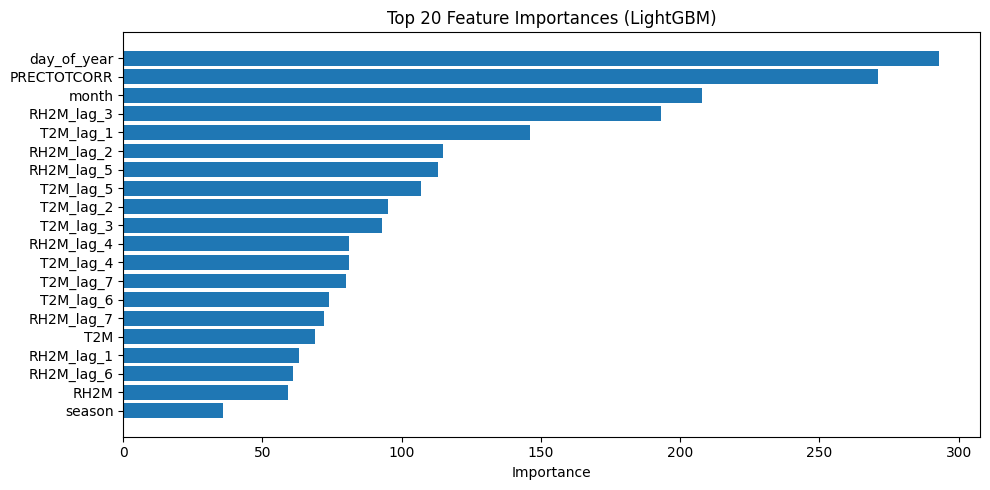

In [ ]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 5))
plt.barh(top_features[::-1], lgb_selector.feature_importances_[important_indices][::-1])
plt.title("Top 20 Feature Importances (LightGBM)")
plt.xlabel("Importance")
plt.tight_layout()
plt.show()

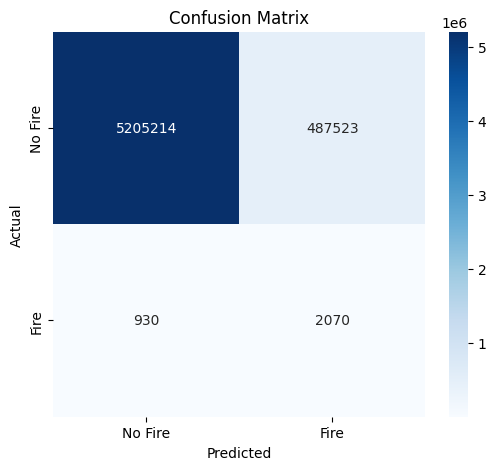

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test, y_final)
plt.figure(figsize=(6,5))
sns.heatmap(cm, annot=True, fmt='d', cmap="Blues", xticklabels=["No Fire", "Fire"], yticklabels=["No Fire", "Fire"])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()


In [ ]:
from sklearn.metrics import classification_report
report = classification_report(y_test, y_final, output_dict=True)
report_df = pd.DataFrame(report).transpose()
print(report_df.round(3))


              precision  recall  f1-score      support
0                 1.000   0.914     0.955  5692737.000
1                 0.004   0.690     0.008     3000.000
accuracy          0.914   0.914     0.914        0.914
macro avg         0.502   0.802     0.482  5695737.000
weighted avg      0.999   0.914     0.955  5695737.000


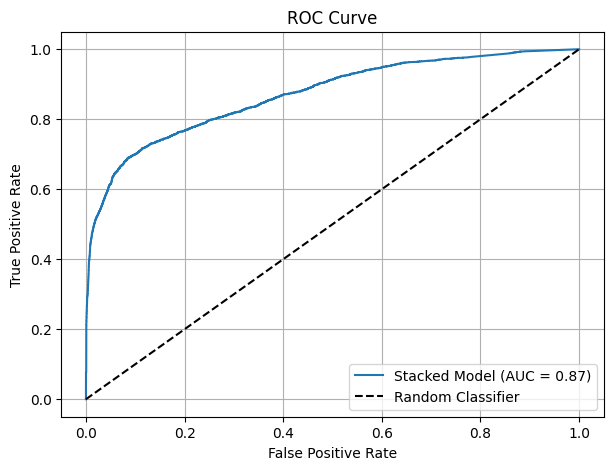

In [ ]:
from sklearn.metrics import roc_auc_score

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f"Stacked Model (AUC = {roc_auc_score(y_test, y_pred_prob):.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier')
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("ROC Curve")
plt.legend(loc="lower right")
plt.grid()
plt.show()


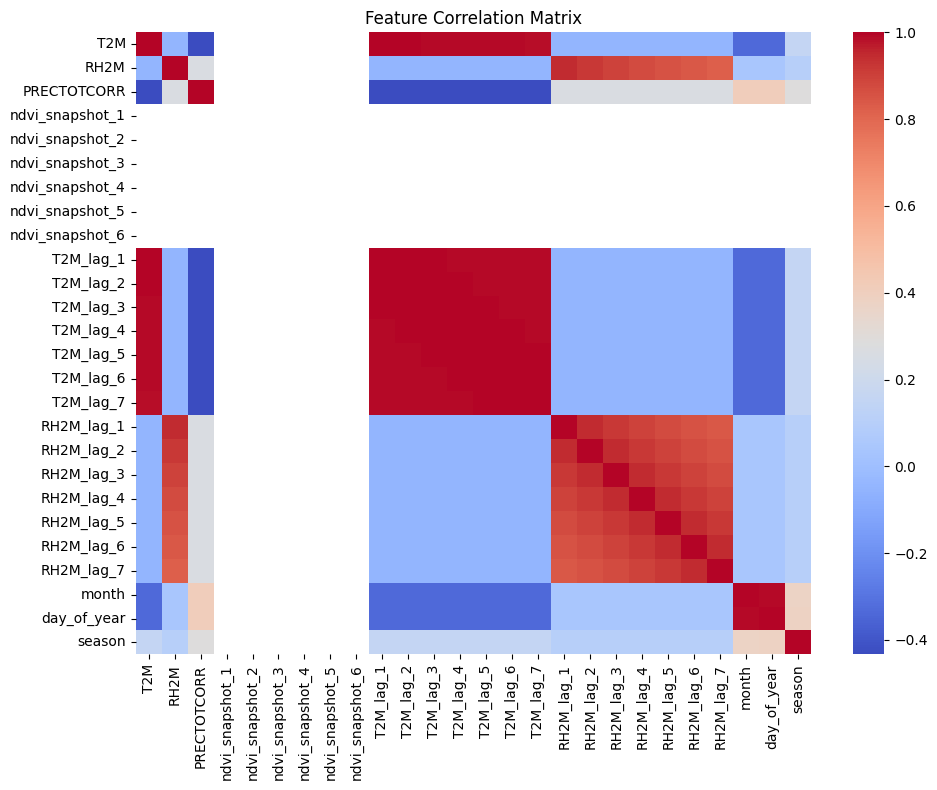

In [ ]:
plt.figure(figsize=(10, 8))
sns.heatmap(X.corr(), cmap='coolwarm', annot=False)
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.show()


In [ ]:
# Organize values in a DataFrame for plotting
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

error_metrics = pd.DataFrame({
    "Metric": ["MSE", "RMSE"],
    "Value": [mse, rmse]
})


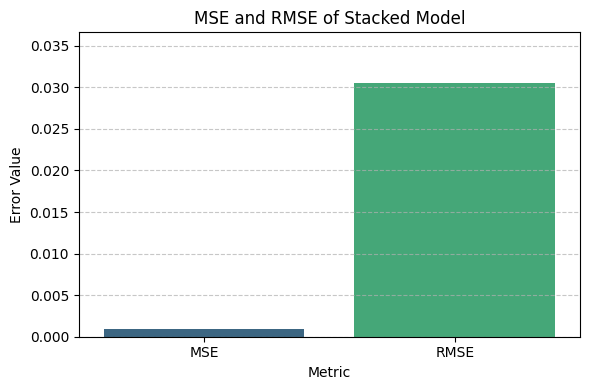

In [ ]:
plt.figure(figsize=(6, 4))
sns.barplot(x="Metric", y="Value", data=error_metrics, palette="viridis")
plt.title("MSE and RMSE of Stacked Model")
plt.ylabel("Error Value")
plt.xlabel("Metric")
plt.ylim(0, error_metrics["Value"].max() * 1.2)  # Add headroom
plt.tight_layout()
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()


In [ ]:
# Retrain LightGBM on the same features used by other models
lgb_top20 = LGBMClassifier(n_estimators=80, max_depth=5, max_bin=64, random_state=42)
lgb_top20.fit(X_train_fs, y_train)

# Update your models dictionary
models = {
    'Stacked Model': stack_model,
    'LightGBM': lgb_top20,
    'Random Forest': RandomForestClassifier(n_estimators=20, max_depth=5).fit(X_train_fs, y_train),
    'Gradient Boosting': GradientBoostingClassifier(n_estimators=20, max_depth=3).fit(X_train_fs, y_train)
}


[LightGBM] [Info] Number of positive: 7000, number of negative: 13283052
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.764882 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1169
[LightGBM] [Info] Number of data points in the train set: 13290052, number of used features: 20
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.000527 -> initscore=-7.548334
[LightGBM] [Info] Start training from score -7.548334
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positiv

In [ ]:
from sklearn.metrics import mean_squared_error
import numpy as np
import pandas as pd

mse_rmse_data = []

for name, model in models.items():
    prob = model.predict_proba(X_test_fs)[:, 1]
    mse_ = mean_squared_error(y_test, prob)
    rmse_ = np.sqrt(mse_)
    mse_rmse_data.append((name, mse_, rmse_))

mse_df = pd.DataFrame(mse_rmse_data, columns=["Model", "MSE", "RMSE"])
print(mse_df.round(4))


               Model     MSE    RMSE
0      Stacked Model  0.0009  0.0305
1           LightGBM  0.0016  0.0402
2      Random Forest  0.0005  0.0222
3  Gradient Boosting  0.0004  0.0205


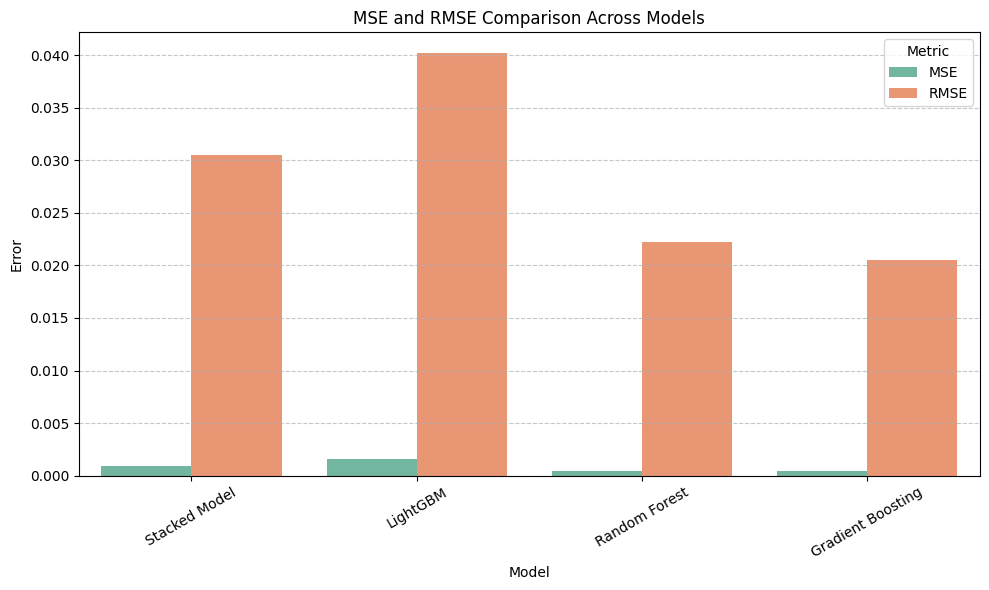

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

mse_melted = mse_df.melt(id_vars="Model", var_name="Metric", value_name="Value")

plt.figure(figsize=(10, 6))
sns.barplot(data=mse_melted, x="Model", y="Value", hue="Metric", palette="Set2")
plt.title("MSE and RMSE Comparison Across Models")
plt.ylabel("Error")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import accuracy_score

train_test_acc = []

for name, model in models.items():
    # Predict on training and test sets
    y_train_pred = model.predict(X_train_fs)
    y_test_pred = model.predict(X_test_fs)

    # Accuracy scores
    train_acc = accuracy_score(y_train, y_train_pred)
    test_acc = accuracy_score(y_test, y_test_pred)

    train_test_acc.append((name, train_acc, test_acc))

# Create a DataFrame
acc_df = pd.DataFrame(train_test_acc, columns=["Model", "Train Accuracy", "Test Accuracy"])
print(acc_df.round(4))


               Model  Train Accuracy  Test Accuracy
0      Stacked Model          0.9990         0.9990
1           LightGBM          0.9984         0.9984
2      Random Forest          0.9995         0.9995
3  Gradient Boosting          0.9996         0.9996


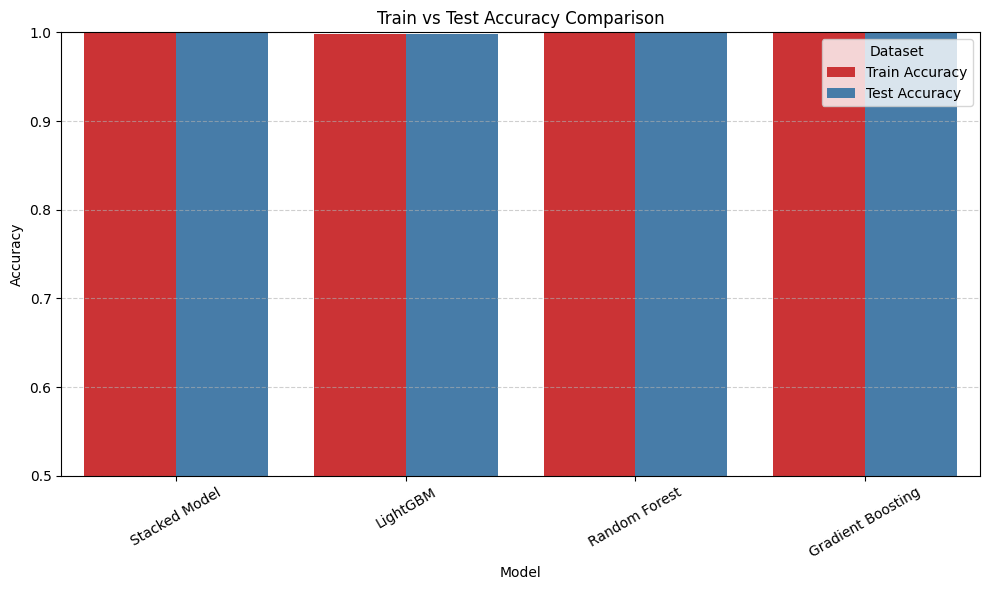

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Reshape the DataFrame for plotting
acc_plot_df = acc_df.melt(id_vars="Model", var_name="Dataset", value_name="Accuracy")

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=acc_plot_df, x="Model", y="Accuracy", hue="Dataset", palette="Set1")
plt.title("Train vs Test Accuracy Comparison")
plt.ylim(0.5, 1.0)
plt.ylabel("Accuracy")
plt.xticks(rotation=30)
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

full_metrics = []

for name, model in models.items():
    # Predictions
    y_train_pred = model.predict(X_train_fs)
    y_test_pred = model.predict(X_test_fs)

    # Metrics
    metrics = {
        "Model": name,
        "Train Accuracy": accuracy_score(y_train, y_train_pred),
        "Train Precision": precision_score(y_train, y_train_pred, zero_division=0),
        "Train Recall": recall_score(y_train, y_train_pred),
        "Train F1": f1_score(y_train, y_train_pred),

        "Test Accuracy": accuracy_score(y_test, y_test_pred),
        "Test Precision": precision_score(y_test, y_test_pred, zero_division=0),
        "Test Recall": recall_score(y_test, y_test_pred),
        "Test F1": f1_score(y_test, y_test_pred),
    }
    full_metrics.append(metrics)

# Create DataFrame
full_df = pd.DataFrame(full_metrics)
full_df_rounded = full_df.copy()
full_df_rounded.iloc[:, 1:] = full_df_rounded.iloc[:, 1:].round(4)
print(full_df_rounded)


               Model  Train Accuracy  Train Precision  Train Recall  Train F1  \
0      Stacked Model          0.9990           0.0941        0.1030    0.0983   
1           LightGBM          0.9984           0.0577        0.1339    0.0806   
2      Random Forest          0.9995           1.0000        0.0080    0.0159   
3  Gradient Boosting          0.9996           0.9991        0.1593    0.2748   

   Test Accuracy  Test Precision  Test Recall  Test F1  
0         0.9990          0.0812       0.0907   0.0857  
1         0.9984          0.0547       0.1277   0.0766  
2         0.9995          1.0000       0.0040   0.0080  
3         0.9996          1.0000       0.1537   0.2664  


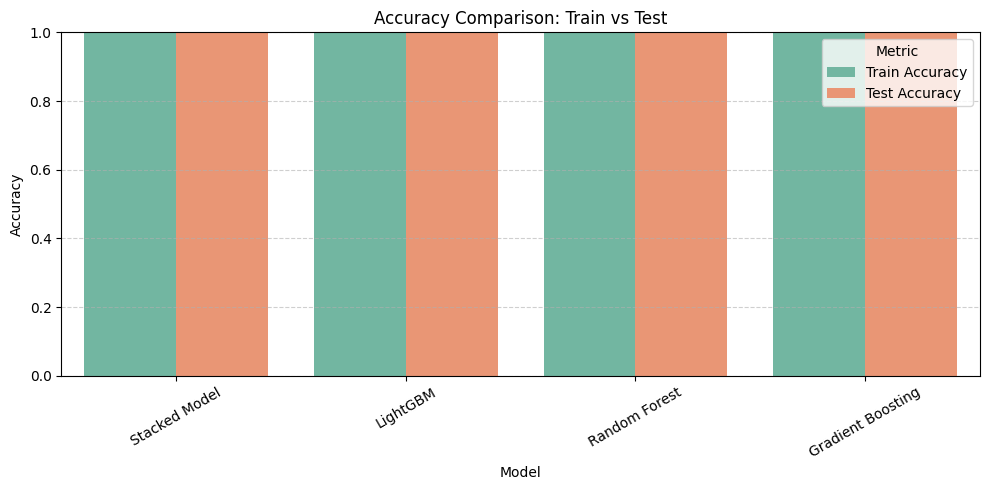

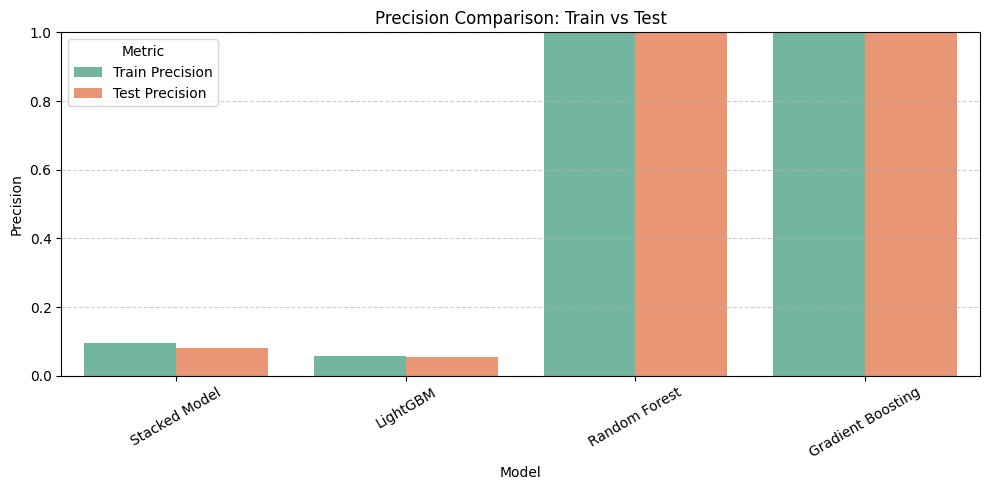

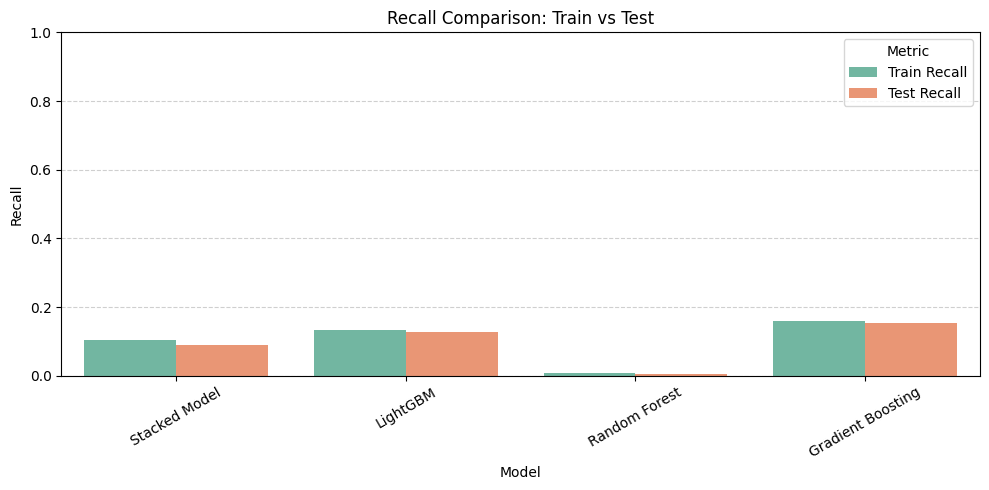

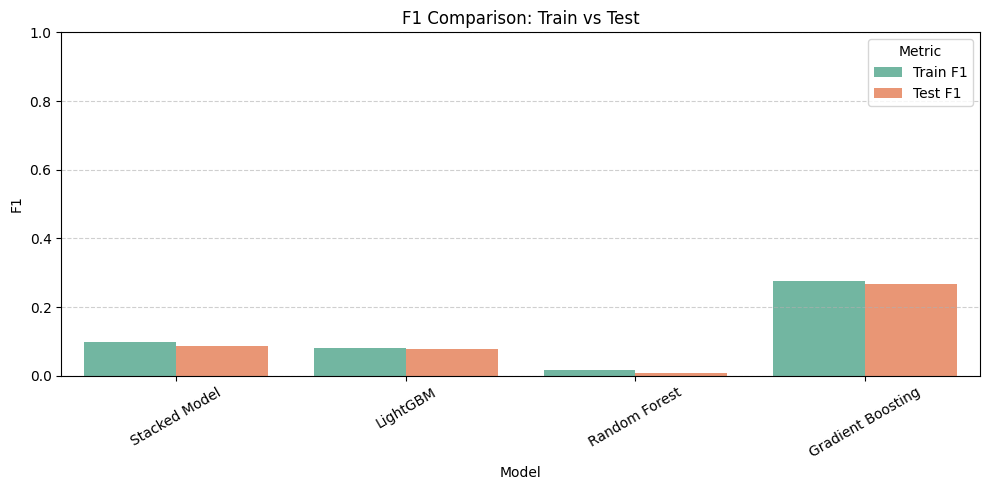

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

melted = full_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
metrics_to_plot = ['Accuracy', 'Precision', 'Recall', 'F1']

for metric in metrics_to_plot:
    plt.figure(figsize=(10, 5))
    sns.barplot(
        data=melted[melted['Metric'].str.contains(metric)],
        x="Model", y="Score", hue="Metric", palette="Set2"
    )
    plt.ylim(0, 1)
    plt.title(f"{metric} Comparison: Train vs Test")
    plt.xticks(rotation=30)
    plt.ylabel(metric)
    plt.grid(axis='y', linestyle='--', alpha=0.6)
    plt.tight_layout()
    plt.show()
